# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import gc
import optuna
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt

In [2]:
%%time
train = pd.read_pickle("../input/creating-smaller-train-test-data/amex_train_data.pkl")
print(train.shape)
train.head(10)

(5531451, 191)
CPU times: user 1.09 s, sys: 3.31 s, total: 4.4 s
Wall time: 25.8 s


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,12a0e12f766016afdfd2ead141ba19222d15c19d55b182...,2017-12-20,0.797363,0.000087,0.009041,0.812012,0.007935,NaN,0.004292,0.006321,NaN,NaN,NaN,0.009995,0.319824,0.007912,0.008339,NaN,0.465820,NaN,NaN,0.173950,0.001649,0.007385,NaN,0.334717,0.006794,0.004200,1.002930,0.614258,0.244507,NaN,0.002167,0.005917,1.004883,1.006836,0.001796,NaN,0.008690,0.006111,0.000847,0.141846,0.002884,0.003910,0.009575,NaN,0.004726,0.049622,1.006836,NaN,0.002178,0.281494,NaN,CO,O,0.008202,0.007046,NaN,1.007812,0.005692,NaN,0.009666,6.0,0.185791,0.009766,0.008568,0.007233,0.006123,0.009575,0.009033,0.006813,0.001554,0.501953,0.005814,NaN,0.005234,0.004421,0.007614,NaN,0.003742,0.006508,NaN,0.004227,0.006607,NaN,0.001895,0.008438,NaN,0.001797,0.001707,0.006489,0.007092,0.009727,0.002293,NaN,0.004658,1.000977,0.006428,0.008904,0.002672,0.002741,0.003616,0.007202,0.009132,NaN,0.0,0.006035,0.004997,NaN,0.003799,0.004047,NaN,1.0,0.007263,0.009018,0.006084,0.000455,0.004700,0.009079,1.004883,0.003143,0.005924,0.008522,0.008293,0.006489,0.009598,0.009071,0.001314,0.002743,0.006813,0.296143,0.138062,0.083069,0.969238,0.007324,0.000885,0.000748,0.002081,NaN,NaN,0.009621,0.006966,0.005596,NaN,1.006836,1.0,NaN,0.004620,NaN,NaN,NaN,1.001953,0.003933,NaN,0.007812,1.0,0.882324,0.0,3.0,0.865723,0.867188,0.0,0.774902,0.434814,0.007034,0.050201,0.007519,1.0,0.004105,0.002430,0.005814,0.008713,NaN,0.006550,0.005707,NaN,0.005215,0.007950,NaN,NaN,NaN,NaN,NaN,0.008041,0.002718,0.003197,NaN,0.005077,0.006756,0.009094,0
1,12a0e12f766016afdfd2ead141ba19222d15c19d55b182...,2018-01-20,0.795410,0.004173,0.007240,0.815430,0.007027,NaN,0.004017,0.003693,NaN,NaN,NaN,0.006538,0.322510,0.006546,0.002676,NaN,0.461914,NaN,NaN,0.178589,0.006668,0.004173,NaN,0.335693,0.006985,0.005661,1.004883,0.610840,0.236816,NaN,0.009827,0.007706,1.009766,1.002930,0.009491,NaN,0.000878,0.001686,NaN,0.138916,0.004826,0.002581,0.000475,NaN,0.007721,0.051605,1.006836,NaN,0.000066,0.286133,NaN,CO,O,0.007912,0.001510,NaN,1.001953,0.006950,NaN,0.002745,6.0,0.188599,0.009247,0.002106,0.006542,0.005939,0.001333,0.005684,0.010246,0.004025,0.505859,0.008324,NaN,0.009224,0.002644,0.003178,NaN,0.000554,0.004513,NaN,0.005123,0.009537,NaN,0.003872,0.000559,NaN,0.000880,0.004032,0.004444,0.009171,0.003325,0.004910,NaN,0.008751,1.007812,0.007629,0.000384,0.002285,0.005836,0.005226,0.006313,0.005009,NaN,0.0,0.007401,0.000581,NaN,0.000210,0.001914,NaN,1.0,0.004200,0.000191,0.000571,0.001352,0.005287,0.003525,1.009766,0.005196,0.000314,0.003071,0.000233,0.004917,0.004311,0.002586,0.008011,0.009407,0.005672,0.298828,0.134399,0.044006,0.977539,0.009605,0.002750,0.000946,0.006470,NaN,NaN,0.009369,0.005768,0.004414,NaN,1.002930,1.0,NaN,0.000782,NaN,NaN,NaN,1.009766,0.003103,NaN,0.008690,1.0,0.881836,0.0,3.0,0.867188,0.866699,0.0,0.774414,0.428711,0.000167,0.048096,0.006111,1.0,0.002966,0.005718,0.007919,0.008797,NaN,0.002369,0.002075,NaN,0.002722,0.007668,NaN,NaN,NaN,NaN,NaN,0.000258,0.009438,0.008446,NaN,0.004543,0.004223,0.005909,0
2,12a0e12f766016afdfd2ead1

# Keep the last record per customer

In [3]:
%%time
train = train.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index().drop(['S_2'], axis='columns')
train['target'] = train['target'].astype('int16')
print(train.shape)
gc.collect()
train.head()

(458913, 189)
CPU times: user 4.87 s, sys: 2.08 s, total: 6.95 s
Wall time: 6.96 s


,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,0.001604,0.007175,NaN,NaN,0.003258,0.070801,0.740234,0.231689,0.008308,0.420410,0.539551,0.192383,NaN,0.149536,0.058411,0.002928,0.153442,0.673340,0.009537,0.000085,0.203491,0.629395,0.326172,NaN,0.034637,0.010262,0.001770,1.007812,0.008514,0.105652,0.112305,0.488281,0.187256,0.166626,0.100098,0.009445,0.007175,0.007397,0.010239,0.063477,0.258545,0.227661,0.014549,0.402344,0.446533,CR,O,0.008659,0.006409,NaN,1.007812,0.005276,NaN,0.007629,6.0,0.184082,0.003944,0.686523,0.005375,0.005470,0.008049,0.008255,0.377930,0.006969,0.304688,0.040375,NaN,0.006565,0.001299,0.001352,NaN,0.002230,0.009163,0.421387,0.006474,0.001067,0.000747,0.002193,0.006344,NaN,0.000026,0.208252,0.001058,0.009354,0.007236,0.009178,0.507324,0.006550,1.001953,0.084717,0.006100,0.000013,0.002901,0.001116,0.001910,0.003256,NaN,0.0,0.001277,0.009972,NaN,0.002331,0.002518,NaN,1.0,0.003511,0.008102,0.007645,0.009415,0.006355,0.008499,1.007812,0.004639,0.001445,0.003080,1.005859,0.003641,0.004639,0.003866,0.005909,0.005459,0.001190,0.917969,0.131836,0.936035,0.972168,0.001281,0.943359,1.002930,1.014648,1.074219,NaN,0.671875,0.007442,0.008675,NaN,1.005859,2.0,NaN,0.000226,NaN,NaN,NaN,1.009766,0.100464,0.928711,0.003658,1.0,0.255859,0.0,4.0,0.260254,0.256592,0.0,0.719727,0.433838,0.003580,0.685059,0.008400,1.0,1.008789,0.999512,1.008789,0.003975,NaN,0.004185,0.005703,NaN,0.006210,0.002716,NaN,NaN,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880371,0.178101,0.034698,1.003906,0.006912,0.165527,0.005550,0.005070,NaN,0.060638,0.008781,0.020630,0.266357,0.026993,0.004978,0.438721,0.402100,0.014694,NaN,0.167603,0.028412,0.000974,NaN,0.339600,0.012924,0.102051,0.242310,0.570801,0.297119,NaN,0.043915,0.014572,0.002911,1.002930,0.003283,0.208496,0.019043,0.406494,0.036102,0.748535,0.017685,0.005878,0.009758,0.127808,0.018661,0.212524,0.412109,0.048981,0.009537,0.363770,0.234009,CO,O,0.008743,0.002939,NaN,1.003906,0.008049,NaN,0.004318,6.0,0.192383,0.007744,0.287109,0.006191,0.007637,0.006172,0.000883,0.007637,0.001278,0.304688,0.014702,NaN,0.004658,0.007927,0.009598,NaN,0.002382,0.008255,0.227783,0.021149,0.000182,0.001541,0.009117,0.006893,NaN,0.006931,0.002119,0.002045,0.009666,0.005375,0.005009,NaN,0.005413,1.008789,0.019669,0.006195,0.005371,0.006271,0.009911,0.000983,0.006668,NaN,0.0,0.009300,0.006462,NaN,0.006504,0.007053,NaN,1.0,0.005089,0.001838,0.008644,0.009468,0.003500,0.000473,1.000977,0.004864,0.000906,0.003830,0.009163,0.004642,0.000195,0.000523,0.006420,0.004974,0.002398,0.920898,0.132812,0.930664,0.977539,0.003212,0.001621,0.008949,0.004364,NaN,NaN,0.007774,0.007458,0.032898,NaN,1.007812,2.0,NaN,0.004742,Na

In [4]:
X_train = train[[col for col in train.columns if col != 'target']]
y_train = pd.DataFrame(train['target'])

print(X_train.shape)
print(y_train.shape)

(458913, 188)
(458913, 1)


In [5]:
cat_cols = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
X_train['D_68'].value_counts()

6.0    231536
5.0    105515
3.0     41897
4.0     41410
2.0     19319
1.0     10224
0.0         0
Name: D_68, dtype: int64

# Competition Metric

In [6]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# Model Training

## Hyperparameter tuning

In [7]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)
y_val = pd.DataFrame(y_val)

'''
def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 31)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr, categorical_feature = cat_cols)
    y_pred = y_val.copy(deep=True)
    y_pred = y_pred.rename(columns={'target':'prediction'})
    y_pred['prediction'] = model.predict_proba(X_val)[:,1]
    score = amex_metric(y_val, y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)
params = study.best_params

print(params)
'''

"\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 31)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 3, 8)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate=learning_rate,\n        max_depth=max_depth, \n        min_child_samples=min_child_samples, \n

In [8]:
params = {
          'n_estimators': 500,
          'learning_rate': 0.05,
         
         
          'feature_fraction': 0.6,
          'subsample': 0.8,
        
          'random_state': 123}

cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


LGBMClassifier(feature_fraction=0.6, learning_rate=0.05, n_estimators=500,
               random_state=123, subsample=0.8)

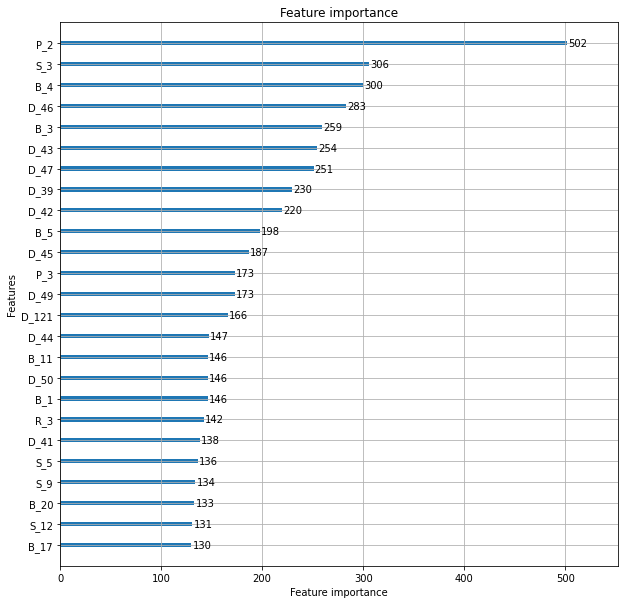

In [9]:
lgb.plot_importance(cls, max_num_features = 25, figsize = (10,10))
plt.show()

# Submission

In [10]:
%%time
test = pd.read_pickle('../input/creating-smaller-train-test-data/amex_test_data.pkl')
test = test.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index().drop(['S_2'], axis='columns')

CPU times: user 12.7 s, sys: 24 s, total: 36.6 s
Wall time: 1min 24s


In [11]:
X_test = test.copy()

In [12]:
y_pred = cls.predict_proba(X_test)[:, 1]

In [13]:
submission = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submission['prediction'] = y_pred

submission

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.029687
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001541
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.037598
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.268144
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.881137
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.012909
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.745058
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.622090
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.391678


In [14]:
submission.to_csv('sub_lgbm_last.csv', index=False)
